In [8]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('combined_incident_tweets.db')

# Load the data from the 'entries' table into a DataFrame
df = pd.read_sql('SELECT * FROM entries', conn)

In [9]:
df

,id,text,relevance
0,'497086296385675264',<HASHTAG> ebola symptoms. early treatment mean...,1
1,'497086297475805184',thinking about telling leadership to make indi...,1
2,'497086300781309952',"we know people are contracting the disease, an...",1
3,'497086305671864321',this is <USER> nurse <HASHTAG> <NUMBER> is at ...,1
4,'497086306443202560',you asked questions about ebola â€” and we hav...,1
...,...,...,...
163713,780474194983346176,will it be easy? nope. will it be worth it? ab...,0
163714,297053317027213312,<USER> all is cool here thank god!,0
163715,1045486858694799360,<USER> she's not adding up. she said she was <...,0
163716,240096723932950528,"just listening to dave days' covers/originals,...",0


In [7]:
!pip install spacy[transformers]
!python -m spacy download en_core_web_trf
import spacy
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.8/758.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
# Ensure spaCy uses the GPU (if available)
spacy.require_gpu()

# Load the pre-trained transformer model (runs on GPU now)
nlp = spacy.load("en_core_web_trf")


In [11]:
def predict(doc):

    if any(ent.label_ in ["EVENT"] for ent in doc.ents):
        return 1
    else:
        return 0

In [12]:
print(df.columns)

Index(['id', 'text', 'relevance'], dtype='object')


In [13]:
# Drop missing values
df = df.dropna(subset=['text', 'relevance'])

# Ensure 'relevance' is numeric (adjust mapping as per dataset)
if df['relevance'].dtype == object:
    df['relevance'] = df['relevance'].map({'yes': 1, 'no': 0})  # Modify based on actual dataset

# Convert to lists
texts = df['text'].tolist()
true_labels = df['relevance'].tolist()

# Debugging step to verify
print(f"Total samples: {len(texts)}")
print(f"First 5 texts: {texts[:5]}")
print(f"First 5 labels: {true_labels[:5]}")


Total samples: 163718
First 5 texts: ['<HASHTAG> ebola symptoms. early treatment means a much better chance of survival. <HASHTAG> ebolaresponse <URL>', "thinking about telling leadership to make individual signs for all the varsity football players for homecoming but that's so much work", 'we know people are contracting the disease, and dying from it, without being noticed. <HASHTAG> ebola', 'this is <USER> nurse <HASHTAG> <NUMBER> is at this very moment being rushed from dallas to atlanta for <HASHTAG> ebola treatment', 'you asked questions about ebola â€” and we have answers']
First 5 labels: [1, 1, 1, 1, 1]


In [14]:
from tqdm import tqdm

predicted_labels = []
results = []

# Adjust batch size based on GPU availability
batch_size = 64 if spacy.prefer_gpu() else 16

# Process texts efficiently using nlp.pipe()
for doc, text in zip(nlp.pipe(texts, batch_size=batch_size, n_process=1, disable=["tagger", "parser"]), texts):
    predicted_class = predict(doc)  # Call your prediction function
    # Append results in a single step
    predicted_labels.append(predicted_class)
    results.append({'text': text, 'predicted_class': predicted_class})

# Debugging Step
print(f"Processed {len(results)} texts successfully!")


/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Processed 163718 texts successfully!


In [15]:
import pandas as pd

# Convert results list into DataFrame
results_df = pd.DataFrame(results)

# Ensure alignment of predicted and true labels
assert len(results_df) == len(true_labels), "Mismatch: predicted and true labels must have the same length!"

# Assign true labels
results_df["true_label"] = true_labels

# Arrange columns for better readability
results_df = results_df[["text", "true_label", "predicted_class"]]

# Debugging step
print(results_df.head())  # Verify correctness
print(results_df.info())  # Check data types


                                                text  true_label  \
0  <HASHTAG> ebola symptoms. early treatment mean...           1   
1  thinking about telling leadership to make indi...           1   
2  we know people are contracting the disease, an...           1   
3  this is <USER> nurse <HASHTAG> <NUMBER> is at ...           1   
4  you asked questions about ebola â€” and we hav...           1   

   predicted_class  
0                0  
1                0  
2                0  
3                0  
4                1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163718 entries, 0 to 163717
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             163718 non-null  object
 1   true_label       163718 non-null  int64 
 2   predicted_class  163718 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ MB
None


In [16]:

results_df.to_csv('predictions_results_spacy.csv', index=False)


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensure evaluation works correctly
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="binary", zero_division=1)
recall = recall_score(true_labels, predicted_labels, average="binary", zero_division=1)
f1 = f1_score(true_labels, predicted_labels, average="binary", zero_division=1)

# Print metrics in a structured format
print("SpaCy Model Performance:")
print(f"{'Metric':<10}{'Value':>10}")
print("-" * 22)
print(f"{'Accuracy:':<10}{accuracy:>10.4f}")
print(f"{'Precision:':<10}{precision:>10.4f}")
print(f"{'Recall:':<10}{recall:>10.4f}")
print(f"{'F1 Score:':<10}{f1:>10.4f}")


SpaCy Model Performance:
Metric         Value
----------------------
Accuracy:     0.5584
Precision:    0.9222
Recall:       0.1275
F1 Score:     0.2240


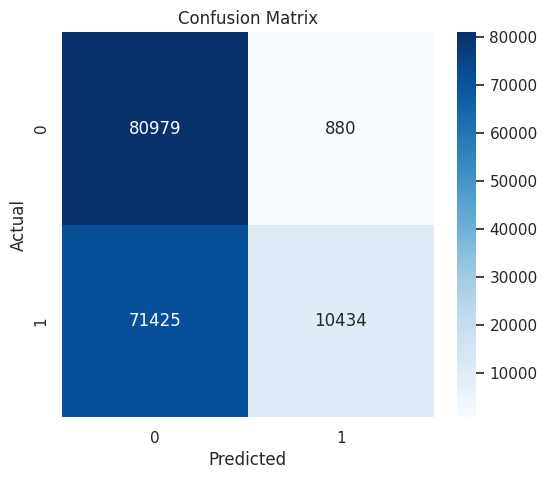

In [23]:
import pandas as pd

file_path = "/content/predictions_results_spacy.csv"  # Adjust if needed
df = pd.read_csv(file_path)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from wordcloud import WordCloud

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Confusion Matrix
cm = confusion_matrix(df['true_label'], df['predicted_class'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(df['true_label']), yticklabels=np.unique(df['true_label']))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
